## **Import Libraries**

In [56]:
# -*- coding: utf-8 -*-
"""
Case E
@author: Amirreza
contact me : arezayan87@gmail.com
This case solves 3D flow over a city.
the benchmark is Case E in Aij institute:
    Guidebook for CFD Predictions
    of Urban Wind Environment
    Architectural Institute of Japan

follow this site for data of the case E : 
https://www.aij.or.jp/jpn/publish/cfdguide/index_e.htm
"""

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# **Define Network | Physics-informed**

In [57]:

class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()

        for i in range(len(layers) - 1):
            layer = nn.Linear(layers[i], layers[i + 1])
            nn.init.xavier_uniform_(layer.weight)  # Xavier initialization for weights
            nn.init.zeros_(layer.bias)             # Initialize biases to zero
            self.layers.append(layer)

    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = torch.tanh(self.layers[i](x))
        x = self.layers[-1](x)
        return x

# Define the network architecture
neu_num = 40 #define number of neurons
layers = [3, neu_num , neu_num, neu_num, neu_num, neu_num, neu_num, neu_num, neu_num,  4]  # Input: (x, y), Output: (u, v, p)
model = PINN(layers).to(device)



# **Define Desired PDE**

In [58]:
def navier_stokes_loss(model, x, y, z, mu):
    x = x.requires_grad_(True)
    y = y.requires_grad_(True)
    z = z.requires_grad_(True)

    uvp = model(torch.cat((x, y, z), dim=1))
    u = uvp[:, 0:1]
    v = uvp[:, 1:2]
    w = uvp[:, 2:3]
    p = uvp[:, 3:4]

    # Calculate gradients
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_z = torch.autograd.grad(u, z, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    v_z = torch.autograd.grad(v, z, grad_outputs=torch.ones_like(v), create_graph=True)[0]

    w_x = torch.autograd.grad(w, x, grad_outputs=torch.ones_like(w), create_graph=True)[0]
    w_y = torch.autograd.grad(w, y, grad_outputs=torch.ones_like(w), create_graph=True)[0]
    w_z = torch.autograd.grad(w, z, grad_outputs=torch.ones_like(w), create_graph=True)[0]

    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
    u_zz = torch.autograd.grad(u_z, z, grad_outputs=torch.ones_like(u_z), create_graph=True)[0]

    v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
    v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]
    v_zz = torch.autograd.grad(v_z, z, grad_outputs=torch.ones_like(v_z), create_graph=True)[0]

    w_xx = torch.autograd.grad(w_x, x, grad_outputs=torch.ones_like(w_x), create_graph=True)[0]
    w_yy = torch.autograd.grad(w_y, y, grad_outputs=torch.ones_like(w_y), create_graph=True)[0]
    w_zz = torch.autograd.grad(w_z, z, grad_outputs=torch.ones_like(w_z), create_graph=True)[0]

    p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]
    p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), create_graph=True)[0]
    p_z = torch.autograd.grad(p, z, grad_outputs=torch.ones_like(p), create_graph=True)[0]

    # Navier-Stokes equations

    f_u = u*u_x + v*u_y + w*u_z + p_x - mu * (u_xx + u_yy + u_zz)
    f_v = u*v_x + v*v_y + w*v_z + p_y - mu * (v_xx + v_yy + v_zz)
    f_w = u*w_x + v*w_y + w*w_z + p_z - mu * (w_xx + w_yy + w_zz)

    # Continuity equation
    continuity = u_x + v_y + w_z

    # Loss calculation with balancing factors
    #loss_f = torch.mean(f_u**2) + torch.mean(f_v**2)+ torch.mean(f_w**2) + torch.mean(continuity**2)
    #return loss_f
    return torch.mean(f_u**2) , torch.mean(f_v**2), torch.mean(f_w**2) , torch.mean(continuity**2)



In [59]:
def boundary_condition_loss(model, x_b, y_b, z_b, u_b, v_b, w_b, p_b=None):
    uvp_b = model(torch.cat((x_b, y_b, z_b), dim=1))
    u_b_pred = uvp_b[:, 0:1]
    v_b_pred = uvp_b[:, 1:2]
    w_b_pred = uvp_b[:, 2:3]
    p_b_pred = uvp_b[:, 3:4]

    loss_u_b = torch.mean((u_b_pred - u_b) ** 2)
    loss_v_b = torch.mean((v_b_pred - v_b) ** 2)
    loss_w_b = torch.mean((w_b_pred - w_b) ** 2)
    loss_p_b = torch.mean((p_b_pred - p_b) ** 2)

    return loss_u_b + loss_v_b + loss_w_b + loss_p_b


In [60]:
def data_loss(model,x,y,z, u_exact, v_exact, w_exact, p_exact=None):
    uvp_pred = model(torch.cat((x, y, z), dim=1))
    u_pred = uvp_pred[:, 0:1]
    v_pred = uvp_pred[:, 1:2]
    w_pred = uvp_pred[:, 2:3]
    p_pred = uvp_pred[:, 3:4]

    loss_u = torch.mean((u_pred - u_exact) ** 2)
    loss_v = torch.mean((v_pred - v_exact) ** 2)
    loss_w = torch.mean((w_pred - w_exact) ** 2)
    loss_p = torch.mean((p_pred - p_exact) ** 2)

    #return loss_u + loss_v + loss_w + (loss_p if p_exact is not None else 0)
    return loss_u , loss_v , loss_w , loss_p

In [61]:
# Load data from CSV
data = pd.read_csv('/content/drive/MyDrive/cavity/CaseE/caseE_Data.csv')
data.insert(6,"p", np.linspace(49,50, len(data)))
data = (data - data.min()) / (data.max() - data.min())
data['z'] = 2
data['v'] = data['w'] = 0
bound = 80
x = torch.tensor(data[['x']][:bound].values, dtype=torch.float32).to(device)
y = torch.tensor(data[['y']][:bound].values, dtype=torch.float32).to(device)
z = torch.tensor(data[['z']][:bound].values, dtype=torch.float32).to(device)
u_exact = torch.tensor(data[['u']][:bound].values, dtype=torch.float32).to(device)
v_exact = torch.tensor(data[['v']][:bound].values, dtype=torch.float32).to(device)
w_exact = torch.tensor(data[['w']][:bound].values, dtype=torch.float32).to(device)
p_exact = torch.tensor(data[['p']][:bound].values, dtype=torch.float32).to(device) if 'p' in data.columns else None



# Example boundary data (you may need to replace this with actual data)

bc_data = pd.read_csv('/content/drive/MyDrive/cavity/CaseE/caseE_BC.csv')
bc_data.insert(6,"p", np.linspace(49,50,len(bc_data)))
bc_data = (bc_data - bc_data.min()) / (bc_data.max() - bc_data.min())
bc_data['u'] = bc_data['v'] = bc_data['w'] = 0
x_b = (torch.tensor(bc_data['x'], dtype=torch.float32).to(device)).reshape(-1,1)
y_b = (torch.tensor(bc_data['y'], dtype=torch.float32).to(device)).reshape(-1,1)
z_b = (torch.tensor(bc_data['z'], dtype=torch.float32).to(device)).reshape(-1,1)
u_b = (torch.tensor(bc_data['u'], dtype=torch.float32).to(device)).reshape(-1,1)  # Boundary u-values
v_b = (torch.tensor(bc_data['v'], dtype=torch.float32).to(device)).reshape(-1,1)  # Boundary v-values
w_b = (torch.tensor(bc_data['w'], dtype=torch.float32).to(device)).reshape(-1,1)  # Boundary w-values
p_b = (torch.tensor(bc_data['p'], dtype=torch.float32).to(device)).reshape(-1,1)  # Boundary w-values



In [ ]:
def total_loss(model, x_data, y_data, z_data, u_exact, v_exact,w_exact,p_exact, mu, x_b , y_b, z_b, u_b, v_b, w_b,p_b):

     # Physics-informed loss
    loss_f = navier_stokes_loss(model, x, y, z, mu)

    # Data loss
    loss_data = data_loss(model, x, y, z, u_exact, v_exact, w_exact, p_exact)

    # Boundary condition loss
    loss_bc = boundary_condition_loss(model, x_b, y_b,z_b, u_b, v_b,w_b, p_b)

    return sum(loss_f) + sum(loss_data) + loss_bc

In [ ]:
total_loss(model, x, y, z, u_exact, v_exact,w_exact,p_exact, mu, x_b , y_b, z_b, u_b, v_b, w_b,p_b)

tensor(0.1895, grad_fn=<AddBackward0>)

# **Adaptive lr and optimization**

In [62]:
# Train parameters
num_epochs = 50000
mu = 1E-5/1.225  # Dynamic viscosity

loss1 = nn.MSELoss()

# Initialize the weights and previous loss values
w_fu = torch.tensor(1.0, requires_grad=False)
w_fv = torch.tensor(1.0, requires_grad=False)
w_fw = torch.tensor(1.0, requires_grad=False)
w_cont = torch.tensor(1.0, requires_grad=False)

w_u = torch.tensor(1.0, requires_grad=False)
w_v = torch.tensor(1.0, requires_grad=False)
w_w = torch.tensor(1.0, requires_grad=False)
w_p = torch.tensor(1.0, requires_grad=False)

w_bc = torch.tensor(1.0, requires_grad=False)

prev_lfu = 1E10
prev_lfv = 1E10
prev_lfw = 1E10
prev_lcont = 1E10
prev_lu = 1E10
prev_lv = 1E10
prev_lw = 1E10
prev_lp = 1E10
prev_lbc = 1E10

# Initialize the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop with dynamic prioritization based on rate of change
for epoch in range(num_epochs):
  model.train()
  optimizer.zero_grad()

  # Forward pass
  lfu , lfv, lfw, lcont = navier_stokes_loss(model, x, y, z, mu)
  uvwp = model(torch.cat((x, y, z), dim=1))
  BC = boundary_condition_loss(model, x_b, y_b,z_b, u_b, v_b,w_b, p_b)

  l_u = loss1(uvwp[:,0:1] , u_exact)
  l_v = loss1(uvwp[:,1:2] , v_exact)
  l_w = loss1(uvwp[:,2:3] , w_exact)
  l_p = loss1(uvwp[:,3:4] , p_exact)


  # Update weights based on the rate of change of the losses
  with torch.no_grad():
      delta_lfu = abs(prev_lfu - lfu.item())
      delta_lfv = abs(prev_lfv - lfv.item())
      delta_lfw = abs(prev_lfw - lfw.item())
      delta_lcont = abs(prev_lcont - lcont.item())

      delat_lu = abs(prev_lu - l_u.item())
      delat_lv = abs(prev_lv - l_v.item())
      delat_lw = abs(prev_lw - l_w.item())
      delta_lp = abs(prev_lp - l_p.item())
      delta_lbc = abs(prev_lbc - BC.item())


      total_delta = delta_lfu + delta_lfv + delta_lfw + delta_lcont + delat_lu + delat_lv + delat_lw + delta_lp + delta_lbc + 1e-8
      # Update weights: give more weight to the losses that are changing less
      w_fu = delta_lfu / total_delta
      w_fv = delta_lfv / total_delta
      w_fw = delta_lfw / total_delta
      w_cont = delta_lcont / total_delta

      wu = delat_lu / total_delta
      wv = delat_lv / total_delta
      ww = delat_lw / total_delta
      wp = delta_lp / total_delta
      wbc = delta_lbc / total_delta

      prev_lfu = lfu.item()
      prev_lfv = lfv.item()
      prev_lfw = lfw.item()
      prev_lcont = lcont.item()
      prev_lu = l_u.item()
      prev_lv = l_v.item()
      prev_lw = l_w.item()
      prev_lp = l_p.item()
      prev_lbc = BC.item()

  #loss = w_fu * lfu + w_fv * lfv + w_fw * lfw +  wu * l_u + wv * l_v + ww * l_w + wp * l_p + wbc * BC
  loss = w_fu * lfu + w_fv * lfv + w_fw * lfw + w_cont * lcont + wu * l_u + wv * l_v + ww * l_w + wp * l_p + wbc * BC
  momentum_loss = ((w_fu * lfu + w_fv * lfv + w_fw * lfw) / 3.0).detach().numpy()
  loss_data = ((wu * l_u + wv * l_v + ww * l_w + wp * l_p) / 4.0).detach().numpy()
  loss_BC = (wbc * BC).detach().numpy()
  continuity_loss = lcont.detach().numpy()

  loss.backward()
  optimizer.step()

  if epoch % 5000 == 0:
      loss_dic = {"momentum_loss":momentum_loss ,
                    "continuity_loss":continuity_loss ,
                    "loss_data":loss_data ,
                    "loss_bc":loss_BC}
      key_max = max(zip(loss_dic.values() , loss_dic.keys()))[1]
      val_max = max(list(loss_dic.values()))

      print(" =========================================================== ")
      print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
      print(f"w_fu: {w_fu:.4f}, w_fv: {w_fv:.4f}, wu: {wu:.4f}, wv: {wv:.4f}")
      print(f"w_cont: {w_cont:.4f}, wp: {wp:.4f}, wBC: {wbc:.4f}")
      print(f"the highest loss is for  {key_max} : {val_max:.6f}")


model.eval()
with torch.no_grad():
    uvp_pred = model(torch.cat((x, y, z), dim=1))
    u_pred = uvp_pred[:, 0:1]
    v_pred = uvp_pred[:, 1:2]
    w_pred = uvp_pred[:, 2:3]
    p_pred = uvp_pred[:, 3:4]


Epoch [1/50000], Loss: 0.1126
w_fu: 0.1111, w_fv: 0.1111, wu: 0.1111, wv: 0.1111
w_cont: 0.1111, wp: 0.1111, wBC: 0.1111
the highest loss is for  loss_bc : 0.066673


KeyboardInterrupt: 

# **Train with LBGFS optimizers**

In [63]:
### LBGFS optimizers

# Define training loop with hybrid optimization
def train_pinn(model, x, y, z, u_exact, v_exact , w_exact ,
               x_b, y_b, z_b, u_b, v_b, w_b ,
               num_epochs_adam, num_epochs_lbfgs,
               prev_lfu , prev_lfv , prev_lfw , prev_lcont , prev_lu , prev_lv , prev_lw , prev_lp , prev_lbc):
  # Optimizers
  loss1 = nn.MSELoss()
  num_epochs = 10000
  mu = 1.85E-5 / 1.225



    #mu = 0.01
  optimizer_adam = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)  # L2 regularization to prevent overfitting
  optimizer_lbfgs =torch.optim.LBFGS(
    model.parameters(),
    lr=0.1,  # or adjust based on your problem
    max_iter=500,  # More iterations for better convergence
    max_eval=None,  # Default
    tolerance_grad=1e-7,  # Increase sensitivity to gradients
    tolerance_change=1e-9,  # Keep default unless facing early stops
    history_size=100  # Use larger history for better approximations
)


  # Early stopping parameters
  best_loss = 1000
  patience = 100
  stop_counter = 0
  best_model = None

  # Phase 1: Adam Optimization
  loss_history = []
  for epoch in range(num_epochs_adam):

    model.train()
    optimizer_adam.zero_grad()

    # Forward pass
    lfu , lfv, lfw, lcont = navier_stokes_loss(model, x, y, z, mu)
    uvwp = model(torch.cat((x, y, z), dim=1))
    BC = boundary_condition_loss(model, x_b, y_b,z_b, u_b, v_b,w_b, p_b)

    l_u = loss1(uvwp[:,0:1] , u_exact)
    l_v = loss1(uvwp[:,1:2] , v_exact)
    l_w = loss1(uvwp[:,2:3] , w_exact)
    l_p = loss1(uvwp[:,3:4] , p_exact)


    # Update weights based on the rate of change of the losses
    with torch.no_grad():
      delta_lfu = abs(prev_lfu - lfu.item())
      delta_lfv = abs(prev_lfv - lfv.item())
      delta_lfw = abs(prev_lfw - lfw.item())
      delta_lcont = abs(prev_lcont - lcont.item())

      delat_lu = abs(prev_lu - l_u.item())
      delat_lv = abs(prev_lv - l_v.item())
      delat_lw = abs(prev_lw - l_w.item())
      delta_lp = abs(prev_lp - l_p.item())
      delta_lbc = abs(prev_lbc - BC.item())


      total_delta = delta_lfu + delta_lfv + delta_lfw + delta_lcont + delat_lu + delat_lv + delat_lw + delta_lp + delta_lbc + 1e-8
      # Update weights: give more weight to the losses that are changing less
      w_fu = delta_lfu / total_delta
      w_fv = delta_lfv / total_delta
      w_fw = delta_lfw / total_delta
      w_cont = delta_lcont / total_delta

      wu = delat_lu / total_delta
      wv = delat_lv / total_delta
      ww = delat_lw / total_delta
      wp = delta_lp / total_delta
      wbc = delta_lbc / total_delta

      prev_lfu = lfu.item()
      prev_lfv = lfv.item()
      prev_lfw = lfw.item()
      prev_lcont = lcont.item()
      prev_lu = l_u.item()
      prev_lv = l_v.item()
      prev_lw = l_w.item()
      prev_lp = l_p.item()
      prev_lbc = BC.item()

    #loss = w_fu * lfu + w_fv * lfv + w_fw * lfw +  wu * l_u + wv * l_v + ww * l_w + wp * l_p + wbc * BC
    loss = w_fu * lfu + w_fv * lfv + w_fw * lfw + w_cont * lcont + wu * l_u + wv * l_v + ww * l_w + wp * l_p + wbc * BC
    momentum_loss = ((w_fu * lfu + w_fv * lfv + w_fw * lfw) / 3.0).detach().numpy()
    loss_data = ((wu * l_u + wv * l_v + ww * l_w + wp * l_p) / 4.0).detach().numpy()
    loss_BC = (wbc * BC).detach().numpy()
    continuity_loss = lcont.detach().numpy()


    loss.backward()
    optimizer_adam.step()

    # Early stopping check
    if loss.item() <  best_loss:
      best_loss = loss.item()
      stop_counter = 0
      best_model = model.state_dict().copy()  # Save the best model
    else:
      stop_counter += 1

      # Save losses for plotting
    loss_history.append((loss.item(), momentum_loss ,continuity_loss, loss_data, loss_BC))

    if stop_counter >= patience:
      print(f"Early stopping at epoch {epoch} with loss: {best_loss :.4f}")
      break

    if epoch % 1000 == 0:
      print(f"Epoch {epoch}, Total Loss: {loss.item():.4f}, "
                f"Momentum Loss: {momentum_loss.item():.4f}, "
                f"Continuity Loss: {continuity_loss.item():.4f}, "
                f"Data Loss: {loss_data.item():.4f}, "
                f"Boundary Loss: {loss_BC.item():.4f}  ")

    # Phase 2: L-BFGS Optimization (use closure function)
    def closure():
      optimizer_lbfgs.zero_grad()
      lfu , lfv, lfw, lcont = navier_stokes_loss(model, x, y, z, mu)
      uvwp = model(torch.cat((x, y, z), dim=1))
      BC = boundary_condition_loss(model, x_b, y_b,z_b, u_b, v_b,w_b, p_b)

      l_u = loss1(uvwp[:,0:1] , u_exact)
      l_v = loss1(uvwp[:,1:2] , v_exact)
      l_w = loss1(uvwp[:,2:3] , w_exact)
      l_p = loss1(uvwp[:,3:4] , p_exact)


      # Update weights based on the rate of change of the losses

      total_delta = delta_lfu + delta_lfv + delta_lfw + delta_lcont + delat_lu + delat_lv + delat_lw + delta_lp + delta_lbc + 1e-8
      # Update weights: give more weight to the losses that are changing less
      w_fu = delta_lfu / total_delta
      w_fv = delta_lfv / total_delta
      w_fw = delta_lfw / total_delta
      w_cont = delta_lcont / total_delta

      wu = delat_lu / total_delta
      wv = delat_lv / total_delta
      ww = delat_lw / total_delta
      wp = delta_lp / total_delta
      wbc = delta_lbc / total_delta

      prev_lfu = lfu.item()
      prev_lfv = lfv.item()
      prev_lfw = lfw.item()
      prev_lcont = lcont.item()
      prev_lu = l_u.item()
      prev_lv = l_v.item()
      prev_lw = l_w.item()
      prev_lp = l_p.item()
      prev_lbc = BC.item()

      #loss = w_fu * lfu + w_fv * lfv + w_fw * lfw +  wu * l_u + wv * l_v + ww * l_w + wp * l_p + wbc * BC
      loss = w_fu * lfu + w_fv * lfv + w_fw * lfw + w_cont * lcont + wu * l_u + wv * l_v + ww * l_w + wp * l_p + wbc * BC
      momentum_loss = ((w_fu * lfu + w_fv * lfv + w_fw * lfw) / 3.0).detach().numpy()
      loss_data = ((wu * l_u + wv * l_v + ww * l_w + wp * l_p) / 4.0).detach().numpy()
      loss_BC = (wbc * BC).detach().numpy()
      continuity_loss = lcont.detach().numpy()
      loss.backward()
      return loss

    print("Switching to L-BFGS optimization...")
    model.load_state_dict(best_model)  # Load the best model from the Adam phase
    for epoch in range(num_epochs_lbfgs):
        model.train()
        optimizer_lbfgs.step(closure)
        if epoch % 100 == 0:
            #loss = w_fu * lfu + w_fv * lfv + w_fw * lfw + w_cont * lcont + wu * l_u + wv * l_v + ww * l_w + wp * l_p + wbc * BC
            print(f"L-BFGS Epoch {epoch}, Total Loss: {loss.item():.6f} ")




In [ ]:
num_epochs_adam = 15000
num_epochs_lbfgs = 4000

prev_lfu = torch.tensor(1E10)
prev_lfv = torch.tensor(1E10)
prev_lfw = torch.tensor(1E10)
prev_lcont = torch.tensor(1E10)
prev_lu = torch.tensor(1E10)
prev_lv = torch.tensor(1E10)
prev_lw = torch.tensor(1E10)
prev_lp = torch.tensor(1E10)
prev_lbc = torch.tensor(1E10)

train_pinn(model, x, y, z, u_exact, v_exact , w_exact,
               x_b, y_b, z_b, u_b, v_b, w_b ,
               num_epochs_adam, num_epochs_lbfgs,
               prev_lfu , prev_lfv , prev_lfw , prev_lcont , prev_lu , prev_lv , prev_lw , prev_lp , prev_lbc)

Epoch 0, Total Loss: 0.0291, Momentum Loss: 0.0003, Continuity Loss: 0.0064, Data Loss: 0.0043, Boundary Loss: 0.0103  
Switching to L-BFGS optimization...
L-BFGS Epoch 0, Total Loss: 0.029093 


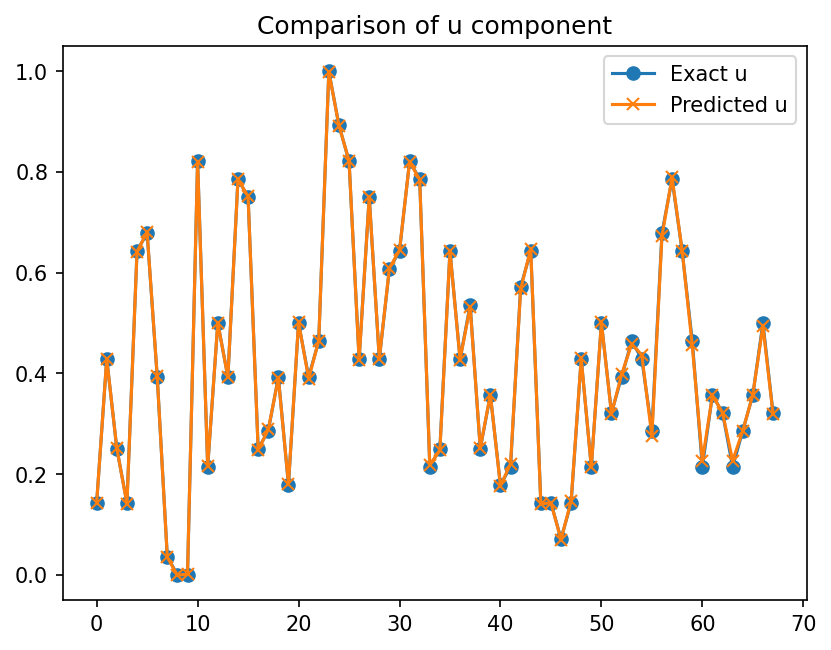

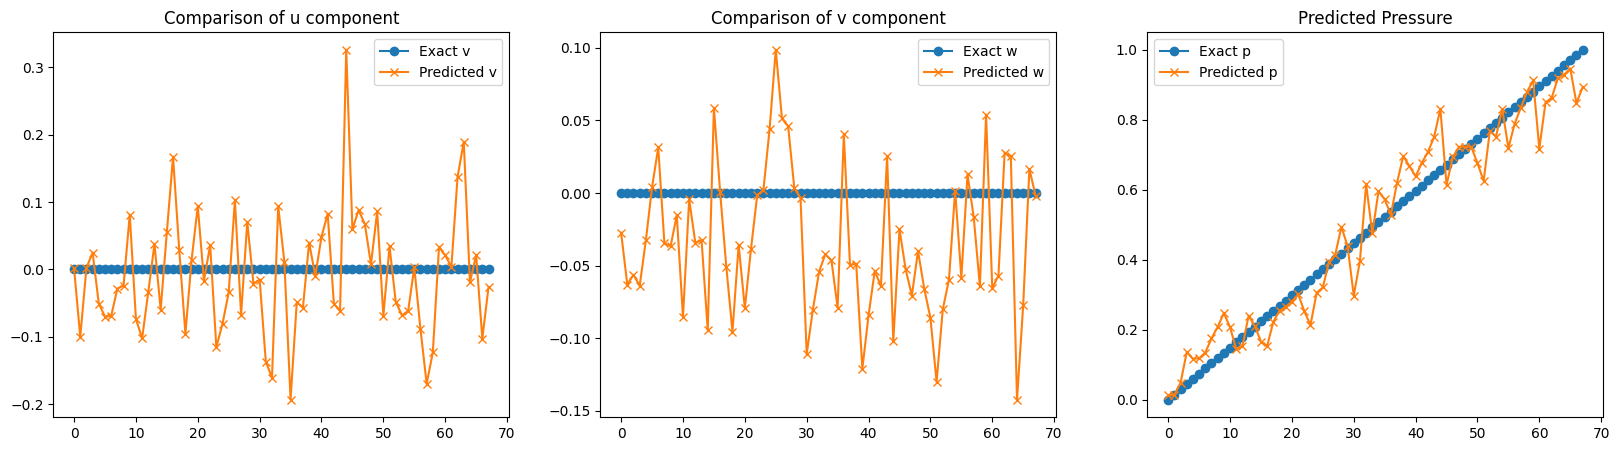

In [51]:
# Convert tensors to numpy arrays
x_train_np = x.cpu().detach().numpy()
y_train_np = y.cpu().detach().numpy()
z_train_np = z.cpu().detach().numpy()
u_exact_np = u_exact.cpu().detach().numpy()
v_exact_np = v_exact.cpu().detach().numpy()
w_exact_np = w_exact.cpu().detach().numpy()
p_exact_np = p_exact.cpu().detach().numpy()

uvp_pred = model(torch.cat((x, y, z), dim=1))
u_pred = uvp_pred[:, 0:1]
v_pred = uvp_pred[:, 1:2]
w_pred = uvp_pred[:, 2:3]
p_pred = uvp_pred[:, 3:4]

u_pred_np = u_pred.cpu().detach().numpy()
v_pred_np = v_pred.cpu().detach().numpy()
w_pred_np = w_pred.cpu().detach().numpy()
p_pred_np = p_pred.cpu().detach().numpy()

plt.figure(dpi = 150)
plt.plot(u_exact_np, label='Exact u', marker='o')
plt.plot(u_pred_np, label='Predicted u', marker='x')
plt.legend()
plt.title('Comparison of u component')


# Plotting the results
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.plot(v_exact_np, label='Exact v', marker='o')
plt.plot(v_pred_np, label='Predicted v', marker='x')
plt.legend()

plt.title('Comparison of u component')

plt.subplot(1, 3, 2)
plt.plot(w_exact_np, label='Exact w', marker='o')
plt.plot(w_pred_np, label='Predicted w', marker='x')
plt.legend()
plt.title('Comparison of v component')

plt.subplot(1, 3, 3)
plt.plot(p_exact_np, label='Exact p', marker='o')
plt.plot(p_pred_np, label='Predicted p', marker='x')
plt.legend()

plt.title('Predicted Pressure')



plt.show()

# **Test with new Data**

In [54]:
bound = 25

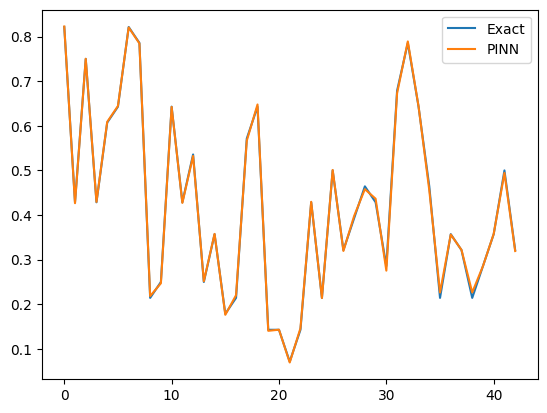

In [55]:
x_test = torch.tensor(data[['x']][bound:].values, dtype=torch.float32).to(device)
y_test = torch.tensor(data[['y']][bound:].values, dtype=torch.float32).to(device)
z_test = torch.tensor(data[['z']][bound:].values, dtype=torch.float32).to(device)
u_test = torch.tensor(data[['u']][bound:].values, dtype=torch.float32).to(device)
v_test = torch.tensor(data[['v']][bound:].values, dtype=torch.float32).to(device)
w_test = torch.tensor(data[['w']][bound:].values, dtype=torch.float32).to(device)
p_test = torch.tensor(data[['p']][bound:].values, dtype=torch.float32).to(device)

uvp_test = model(torch.cat((x_test, y_test, z_test), dim=1))
ut_pred = uvp_test[:,0:1]

ut_pred = ut_pred.cpu().detach().numpy()
plt.plot(u_test.cpu(), label = "Exact")
plt.plot(ut_pred, label = "PINN")
#plt.ylim(0.2,0.8)
plt.legend()


In [ ]:
x.shape

torch.Size([30, 1])

<ipython-input-53-e0e20f5e42cd>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(name='RdBu_r', lut=None)


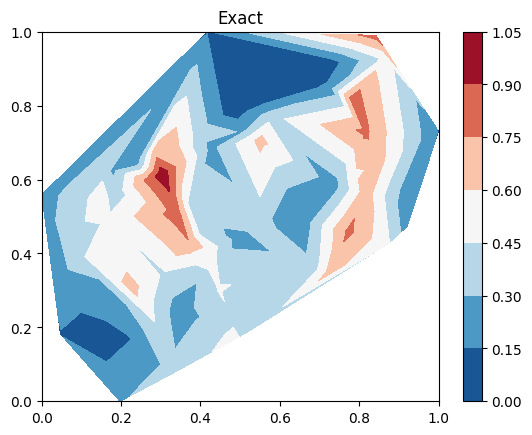

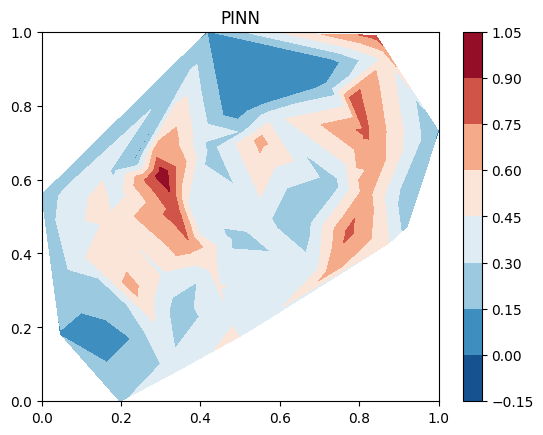

In [53]:
import matplotlib.cm as cm
xx = ((torch.tensor(data['x'][:], dtype=torch.float32)).reshape(-1,1)).to(device)
yy = ((torch.tensor(data['y'][:], dtype=torch.float32)).reshape(-1,1)).to(device)
zz = ((torch.tensor(data['z'][:], dtype=torch.float32)).reshape(-1,1)).to(device)
uu = ((torch.tensor(data['u'][:], dtype=torch.float32)).reshape(-1,1)).to(device)

uvwp_test = model(torch.cat((xx, yy, zz), dim=1))
up = uvwp_test[:,0:1]

cmap = cm.get_cmap(name='RdBu_r', lut=None)
plt.subplots(1,1)
plt.title("Exact")
plt.tricontourf(xx.cpu().flatten(), yy.cpu().flatten(), uu.cpu().flatten(), cmap = 'RdBu_r')
plt.colorbar()

plt.subplots(1,1)
plt.title("PINN")
plt.tricontourf(xx.cpu().flatten(),yy.cpu().flatten(),up.cpu().detach().numpy().flatten(), cmap="RdBu_r")
plt.colorbar()
plt.show()
